In [1]:
#4qubitのSStronglyEntanglingLayers(https://docs.pennylane.ai/en/stable/code/api/pennylane.StronglyEntanglingLayers.html)
import pennylane as qml
from pennylane import numpy as np
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from pennylane.optimize import AdamOptimizer
from pennylane.optimize import AdagradOptimizer
import matplotlib.pyplot as plt

In [2]:
#HWE回路のパラメータの読み込み
weights_005= np.load('/home/ryo_mtmt/NTangled_Datasets/Hardware_Efficient/4_Qubits/Depth_6/hwe_4q_ps_5_6_weights.npy')
weights_035= np.load('/home/ryo_mtmt/NTangled_Datasets/Hardware_Efficient/4_Qubits/Depth_6/hwe_4q_ps_35_6_weights.npy')

#データセットの読み込み
train_path = '/home/ryo_mtmt/xanadu_ntangle_dataset/train_HWE_4q_6_005_035_no3.csv'
train_data = np.loadtxt(train_path, delimiter=',',)
X_train = train_data[:, :-1] 
y_train = train_data[:, -1]

test_path = '/home/ryo_mtmt/xanadu_ntangle_dataset/test_HWE_4q_6_005_035_no3.csv'
test_data = np.loadtxt(test_path, delimiter=',',)
X_test = test_data[:, :-1] 
y_test = test_data[:, -1] 


In [5]:
n_wires = 4
dev = qml.device('default.qubit', wires=n_wires)
@qml.qnode(dev)
def circuit(params,x):
    #HWE回路のパラメータの選択
    if x[-1] == -1:
        gen_params = weights_005
    else:
        gen_params = weights_035
    x = x[:-1]
    x = x.reshape( ( int(x.shape[0]/2) , 2) )

    #積状態の入力
    for i in range(n_wires):
        qml.RZ(x[i][1],wires=i)
        qml.RY(x[i][0],wires=i)
    
    #HWE回路
    for layer in range(gen_params.shape[0]):
        for i in range(n_wires):
            qml.U3(gen_params[layer][i][0],gen_params[layer][i][1],gen_params[layer][i][2],wires=i)
        for i in range(int(n_wires/2)):
            qml.CZ(wires=[2*i,2*i+1])
        for i in range(n_wires):
            qml.U3(gen_params[layer][i][0],gen_params[layer][i][1],gen_params[layer][i][2],wires=i)
        for i in range(int((n_wires-1)/2)):
            qml.CZ(wires=[2*i+1,2*i+2])
    
    qml.StronglyEntanglingLayers(params, wires=range(4))

    return qml.expval(qml.PauliZ(0))


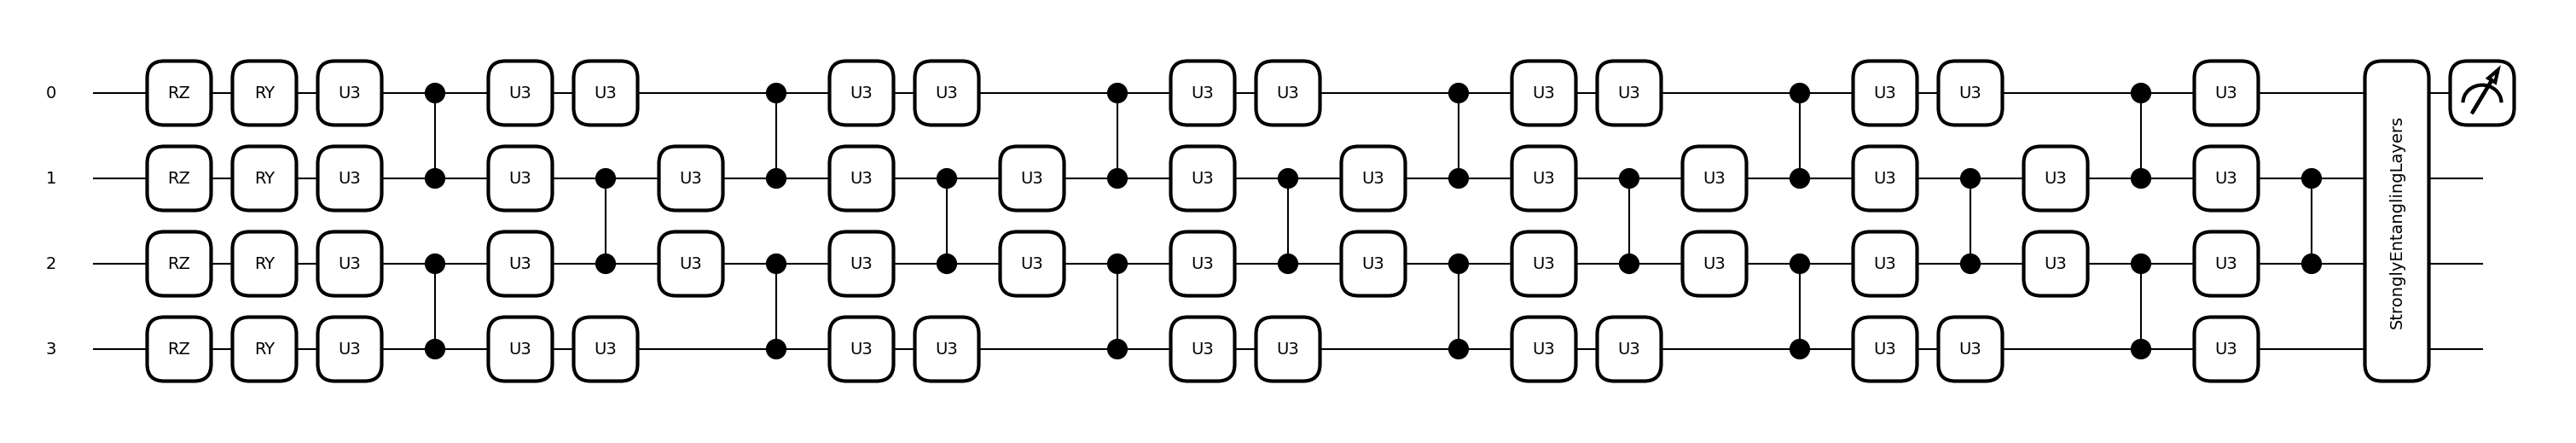

Cost after step 1: 1.0577636376772375
Cost after step 2: 1.0491941503705107
Cost after step 3: 1.0407120899249498
Cost after step 4: 1.032314898822998
Cost after step 5: 1.0240359509180568
Cost after step 6: 1.0159120622444189
Cost after step 7: 1.0079798280401637
Cost after step 8: 1.000274202130405
Cost after step 9: 0.992822559179362
Cost after step 10: 0.9856391288945638
Cost after step 11: 0.9787240690895003
Cost after step 12: 0.9720690639713578
Cost after step 13: 0.9656664290199483
Cost after step 14: 0.9595149886192628
Cost after step 15: 0.9536192894827025
Cost after step 16: 0.9479845801605457
Cost after step 17: 0.9426121616386299
Cost after step 18: 0.9374985672022037
Cost after step 19: 0.9326383739973468
Cost after step 20: 0.9280276323672748
Cost after step 21: 0.9236663300084625
Cost after step 22: 0.9195598914976205
Cost after step 23: 0.9157193101136559
Cost after step 24: 0.9121593630953497
Cost after step 25: 0.9088950174683441
Cost after step 26: 0.905936826414417

In [8]:
np.random.seed(42)  # ここで好きな整数を指定
shape = qml.StronglyEntanglingLayers.shape(n_layers = 5, n_wires = 4)
params = np.random.random(size=shape)
params.requires_grad = True  # 勾配計算を有効にする

def loss(p):
    predictions = np.array([circuit(p, x) for x in X_train])
    return np.mean((predictions - y_train) ** 2)

opt = AdamOptimizer(0.01)
steps = 200

fig, ax =qml.draw_mpl(circuit)(params, X_train[0])
plt.show()
plt.close()
#print(qml.draw(circuit)(params,X_train[0]))

loss_values = []
loss_values.append(loss(params))
for i in range(steps):
    params = opt.step(loss, params)
    current_loss = loss(params)
    loss_values.append(current_loss)
    print(f"Cost after step {i + 1}: {current_loss}")
        
predictions = np.array([np.sign(circuit(params, x)) for x in X_test])
accuracy = np.mean(predictions == y_test)
print(f"Test accuracy: {accuracy * 100:.2f}%")

print(loss_values)

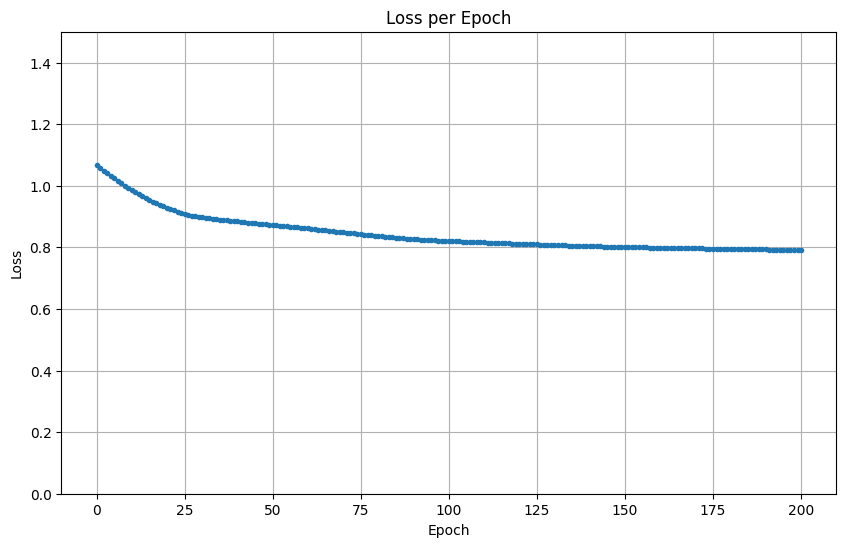

In [9]:
plt.figure(figsize=(10, 6))
plt.plot(range(0, steps + 1), loss_values, marker='.')
plt.title('Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0, 1.5])
plt.grid()
plt.show()